### Plots for RWKV preprint

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from pathlib import Path
from typing import Union

In [21]:
BASE_PATH = Path("data/")

In [31]:
def groupby_first_n(df: pd.DataFrame, args: Union[str, list[str]] , n: int = None): #  -> pd.GroupBy: 
    """ Keeps up to the first N in a groupby. If n=None, keeps largest possible. """
    new_df = []
    for els, dfs in df.groupby(args): 
        new_df.append(dfs[:n])
    return pd.concat(new_df).groupby(args)

### Time Plot

In [33]:
df = pd.read_csv(BASE_PATH / "inference_results_hf.csv")
df2 = pd.read_csv(BASE_PATH / "inference_results_rwkv.csv")

In [36]:
df_ = groupby_first_n(df, ["model_name", "strategy"], n=128)[["cpu_time"]].sum()
df2_ = groupby_first_n(df2, ["model_name", "strategy"], n=128)[["cpu_time"]].sum()
main_df = pd.concat([df_, df2_]).reset_index()

In [38]:
scale = {"B": 10**9, "m": 10**6, "b": 10**9}
main_df["model_name"] = main_df["model_name"].str.replace("b5", "b").str.replace("b7", "b")
main_df["class"] = main_df["model_name"].apply(lambda x: '-'.join(x.split("/")[1].split("-")[:-1]))
main_df["size"] = main_df["model_name"].apply(lambda x: float(x.split("-")[-1][:-1]) * scale[x.split("-")[-1][-1]])
main_df["strategy"] = main_df["strategy"].apply(lambda x: "cuda" if "cuda" in x else "cpu")
main_df = main_df.sort_values(["size", "strategy"])

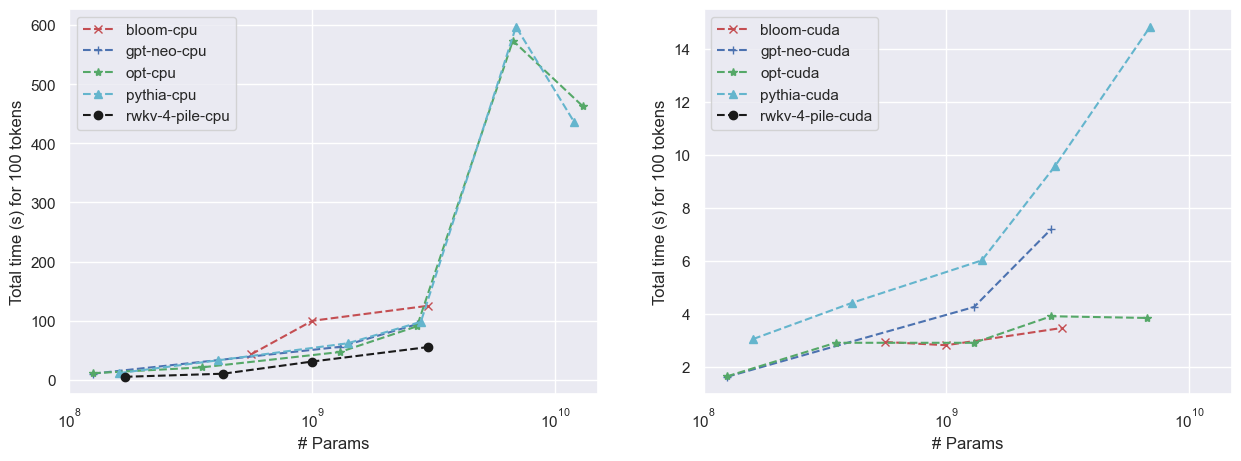

In [39]:
colors = "rbgck"
icons = "x+*^o"
alpha = {"cpu": 0.5, "cuda": 1.0}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, (class_, model_df) in enumerate(main_df.groupby("class")): 
    for s, strategy in enumerate(["cpu", "cuda"]):
        mask = model_df["strategy"] == strategy
        axs[s].plot(model_df[mask]["size"], model_df[mask]["cpu_time"]*10**(-6), f'{colors[i]}{icons[i]}--', label=f"{class_}-{strategy}")

for s in [0, 1]: 
    axs[s].legend()
    axs[s].set_xscale("log")
    # axs[s].set_yscale("log")
    axs[s].set_xlabel("# Params")
    axs[s].set_ylabel("Total time (s) for 100 tokens")
    axs[s].set_xlim(10**8, 1.5*10**10)

### VRAM plot

In [10]:
df = pd.read_csv(BASE_PATH / "inference_results_hf.csv")
df2 = pd.read_csv(BASE_PATH / "inference_results_rwkv.csv")

In [11]:
df["memory"] = np.maximum(df["cpu_memory_usage"].values, df["cuda_memory_usage"].values)
df2["memory"] = np.maximum(df2["cpu_memory_usage"].values, df2["cuda_memory_usage"].values)

df_ = df.groupby(["model_name", "strategy"])[["memory"]].max()
df2_ = df2.groupby(["model_name", "strategy"])[["memory"]].max()
main_df = pd.concat([df_, df2_]).reset_index()

In [12]:
scale = {"B": 10**9, "m": 10**6, "b": 10**9}
main_df["model_name"] = main_df["model_name"].str.replace("b5", "b").str.replace("b7", "b")
main_df["class"] = main_df["model_name"].apply(lambda x: '-'.join(x.split("/")[1].split("-")[:-1]))
main_df["size"] = main_df["model_name"].apply(lambda x: float(x.split("-")[-1][:-1]) * scale[x.split("-")[-1][-1]])
main_df["strategy"] = main_df["strategy"].apply(lambda x: "cuda" if "cuda" in x else "cpu")
main_df = main_df.sort_values(["size", "strategy"])

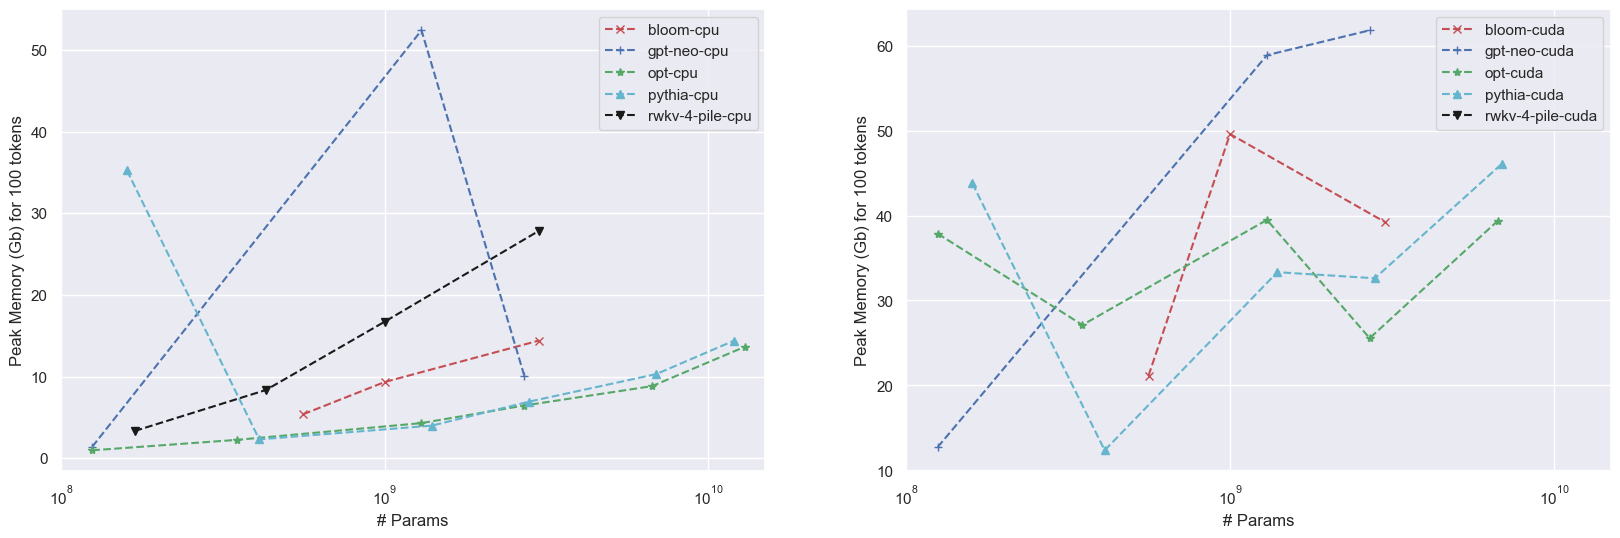

In [13]:
colors = "rbgck"
icons = "x+*^v"
alpha = {"cpu": 0.5, "cuda": 1.0}

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

for i, (class_, model_df) in enumerate(main_df.groupby("class")): 
    for s, strategy in enumerate(["cpu", "cuda"]):
        mask = model_df["strategy"] == strategy
        axs[s].plot(model_df[mask]["size"], model_df[mask]["memory"]*10**(-6), f'{colors[i]}{icons[i]}--', label=f"{class_}-{strategy}") # , alpha=alpha[strategy])

for s in [0, 1]: 
    axs[s].legend()
    axs[s].set_xscale("log")
    # axs[s].set_yscale("log")
    axs[s].set_xlabel("# Params")
    axs[s].set_ylabel("Peak Memory (Gb) for 100 tokens")
    axs[s].set_xlim(10**8, 1.5*10**10)